# Automated pipeline for skullstrip of sheep 
using ANTs, FSL, and nipype

Outline:

a. generate transformation files <br>
b. Ants ApplyTransforms to bring the mask into individual sheep space <br>
c. skull strip with fsl ApplyMask <br>

- Apply steps a - c to all sheep in 'files' folder <br>
this is achieved with nipype, using MapNodes to iterate steps over each file

1. Select files from folder (folder needs to contain template and mask as well)
2. Configure nodes for registration, tranformation, apply-mask
3. Set up a datasink for the resulting skull-stipped files
4. Connect the nodes in a workflow and run

you can visualise steps 1-4 in a automated graph.

# Import Required Libraries
Import the necessary libraries, including Nipype, ANTs, and FSL.

In [427]:
# Import Required Libraries
import numpy as np
import nipype.interfaces.ants as ants
import nipype.interfaces.fsl as fsl
from nipype import SelectFiles, Node, MapNode
import nibabel as nib
from nilearn import plotting, image

In [428]:
def quick_slice(f_name):
    '''quickly view a file as some slices'''

    plotting.plot_anat(f_name, title='', 
                       display_mode='ortho', 
                       dim=0,
                       cut_coords=[-10,-80,-25], 
                       draw_cross=False, 
                       radiological=True)

# Select files you want to skullstrip
using nipype 'SelectFiles' on the directory of interest

In [429]:
# String template with {}-based strings
templates = {#'anat': 'RT*_*_{structural}.nii.gz',
             'func': 'RT*_{functional}.nii.gz',
             'template': 'rsfMRI_template0.nii.gz',
             'mask' : 'rsfMRI_template_mask.nii.gz'}

# Create SelectFiles node
sf = Node(SelectFiles(templates), name='selectfiles')

# Location of the dataset folder
sf.inputs.base_directory = '/Users/tijmenvanslageren/Desktop/BET_pipeline/files'

# Feed {}-based placeholder strings with values
# sf.inputs.structural = 'T1_MPRAGE'
sf.inputs.functional = 'rsfMRI'



In [430]:
sf.run().outputs

241217-20:32:46,688 nipype.workflow INFO:
	 [Node] Setting-up "selectfiles" in "/private/var/folders/hr/60l6nnq51j785m1z1g0w32q00000gp/T/tmp4pe9mf_y/selectfiles".
241217-20:32:46,703 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
241217-20:32:46,705 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000855s.



func = ['/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT090_28d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT090_Pre_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT095_6d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT095_28d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT095_Pre_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT096_6d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT096_28d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT096_Pre_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT098_6d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT098_28d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT098_Pre_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/files/RT099_6d_rsfMRI.nii.gz', '/Users/tijmenvanslageren/Desktop/BET_pipeline/

# Get the minimum image from the timeseries
use fsl to get the smallest image on a dimension 

In [431]:
Min = MapNode(fsl.maths.MinImage(), 
              iterfield=['in_file'],
              name='Min')

In [432]:
dil = MapNode(fsl.maths.DilateImage(), iterfield=['in_file'], name='Dilate')
dil.inputs.operation= 'mean'
               

# Configure ANTs quick Registration 
to produce the neccessary GenericAffine and Warp files.

In [433]:
from nipype.interfaces.ants import RegistrationSynQuick

# registration iterating over the 'moving image' with the list from sf
regSyn = MapNode(RegistrationSynQuick(),
                 iterfield=['moving_image'],
                 name='Registration_SynQuick')

regSyn.inputs.dimension = 3
regSyn.inputs.precision_type = 'float'
regSyn.inputs.histogram_bins = 32


# Apply tranformation to mask
bring the mask into individual sheep space with inverse transform and inverse warp

In [434]:
# import the ants 'apply transforms' module
from nipype.interfaces.ants import ApplyTransforms

# Assign the ApplyTransforms module to 'at'
# interate the reference and transforms (NOT input_file, as this is always mask)
at = MapNode(ApplyTransforms(), name='ApplyTransforms', 
           iterfield=['reference_image', 
                      'transforms'])

at.inputs.dimension = 3

# invert the out_matrix from regSyn? - Yes
at.inputs.invert_transform_flags = [True]

# specify multilabel cost function
at.inputs.interpolation = 'MultiLabel'

# Configure FSL ApplyMask
Apply the mask from the template to the inverse warped sheep.

In [435]:
# import relevant module from fsl maths
from nipype.interfaces.fsl import maths

bet1 = MapNode(maths.ApplyMask(), 
               iterfield=['in_file',
                          'mask_file'],
               out_file = '*.brain.nii.gz',
               name= 'Apply_Mask')

# Set up the datasink
and configure the output to be resticted to just files we're interested in

In [436]:
from nipype.interfaces.io import DataSink

# Create DataSink object
sinker = Node(DataSink(), name='sink')

# Name of the output folder
sinker.inputs.base_directory = '/Users/tijmenvanslageren/Desktop/BET_pipeline/sink'


# Set up workflow
set up the skullstrip workflow

In [437]:
from nipype import Workflow

wf = Workflow(name='test_sf_to_sink', 
              base_dir='/Users/tijmenvanslageren/Desktop/BET_pipeline/test_workflow')

wf.connect([(sf, regSyn,     [("template", "fixed_image")]),
            (sf, Min,        [("func", "in_file")]),
            (Min, regSyn,    [("out_file", "moving_image")]),
            (sf, at,         [("mask", "input_image")]),
            (regSyn, at,     [("inverse_warped_image", "reference_image"),
                              ("out_matrix", "transforms")]),
            (at, dil,        [("output_image", "in_file")]),
            (dil, bet1,      [("out_file", "mask_file")]),
            (sf, bet1,       [("func", "in_file")]),
            (bet1, sinker,   [("out_file", "in_file")])
            ])
# wf.run() # comment out - takes 7min to run on 55 files

# Visualise workflow
as an acyclic graph

241217-20:32:47,494 nipype.workflow INFO:
	 Generated workflow graph: /Users/tijmenvanslageren/Desktop/BET_pipeline/graph.png (graph2use=orig, simple_form=True).


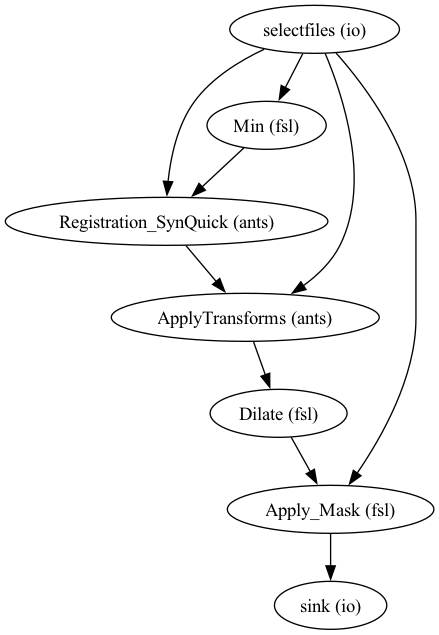

In [438]:
wf.write_graph(graph2use='orig', dotfilename='./graph.dot')
from IPython.display import Image
Image(filename="/Users/tijmenvanslageren/Desktop/BET_pipeline/graph.png")


In [439]:
result = image.load_img('/Users/tijmenvanslageren/Desktop/BET_pipeline/sink/RT090_Pre_rsfMRI_masked.nii.gz')
result_slice = image.index_img(result, 0)

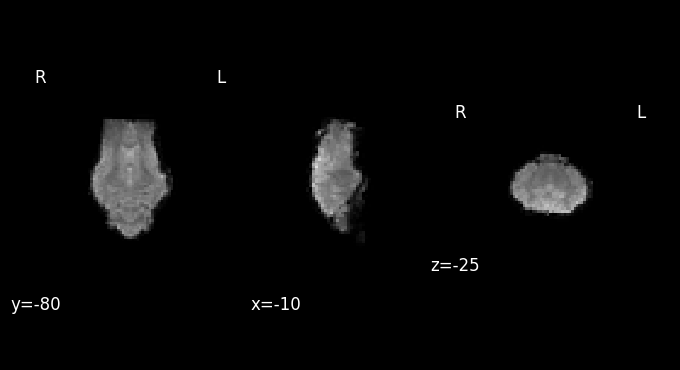

In [440]:
quick_slice(result_slice)

# Plot the results
skullstripped data in matplotlib

In [441]:
# import libraries
import os
import nibabel as nib
import matplotlib.pyplot as plt

# Define the base directory and file pattern
base_dir = '/Users/tijmenvanslageren/Desktop/BET_pipeline/sink/'
file_pattern = 'RT*_rsfMRI_masked.nii.gz'

# Get the list of files (just pre-surgery in this case)
file_paths = []
for root, dirs, files in os.walk(base_dir):
    for file in files: 
        #  erase 'Pre' here to grab ALL the skullstripped files
        if file.endswith('Pre_rsfMRI_masked.nii.gz'): 
            file_paths.append(os.path.join(root, file)) 

# Ensure we have exactly 21 files
print(len(file_paths))



1


note 1 'Pre' surgery file is retrived

Inspect result

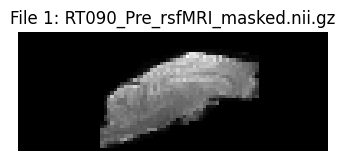

In [442]:
'''Comment on result : all 55 volumes have been skullstripped. Here the 1
pre surgery sheep is displayed, the sagittal section of the brain is shown'''

# Load and plot the files
for i, file_path in enumerate(file_paths):
    # Load the file with nibabel
    img = nib.load(file_path)
    data = img.get_fdata()

    # Plot a slice
    plt.figure(figsize=(4, 4))
    plt.imshow(np.rot90(data[48 , :, :, 0]), cmap='gray')
    plt.title(f'File {i+1}: {os.path.basename(file_path)}')
    plt.axis('off')
    plt.tight_layout


# END